In [16]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline

In [17]:
alpha = 0.5
gamma_E = 0.9

def go_tree_cycle(k):
    E = defaultdict(lambda: 1)
    pseudo_counts = []
    for _ in range(10000):
        for i in range(1,k+1):
            E[('s', 'start')] = (1-alpha)*E[('s', 'start')] + alpha * gamma_E * E[('s0', str(i))]
            E[('s0', str(i))] = (1-alpha)*E[('s0', str(i))]
            
        pseudo_counts.append(np.log(E[('s', 'start')]) / np.log(1-alpha))
    return pseudo_counts

In [18]:
k_range = [10, 20, 30]
results = []

for k in k_range:
    pseudo_counts = go_tree_cycle(k)
    results.append(pseudo_counts)

/home/liza/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


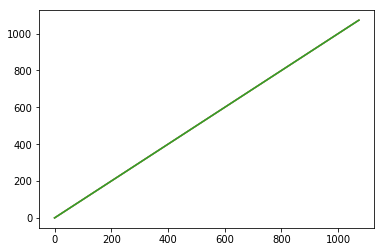

In [19]:
for i in range(len(k_range)):
    plt.plot(results[i])

In [20]:
results[0][-10:]

[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]

In [21]:
from tabular_environments.chain_environment import SimpleChain

In [22]:
def plot_results(results, titles, dim_range):
    linewidth=4
    fontsize=15
    
    num_plots = len(results)
    plt.figure(figsize=(7*num_plots,5))
    
    for i in range(num_plots):    
        ax = plt.subplot(1, num_plots, i+1)
        for key in sorted(results[i].keys()): 
            arr = results[i][key]

            min_ = arr.min(axis=0)
            max_ = arr.max(axis=0)
            mean = arr.mean(axis=0)

            plt.plot(dim_range, mean, label=key, linewidth=linewidth)
            ax.fill_between(dim_range, min_, max_, alpha=0.25)

        plt.legend(loc='upper right')
        plt.grid()
        plt.ylabel('num epochs', fontsize=fontsize)
        plt.xlabel('dim', fontsize=fontsize)
        plt.title(titles[i], fontsize=fontsize)

In [44]:
def Q_E_learning(env,
                 alpha=0.2, gamma=0.99, gamma_E=0.9,
                 ucb_flag=False, rew_bonus_flag=False, w=1,
                 return_trajectory=True,
                 max_num_episodes=2000):
    
    n_states = env.observation_space.shape[0]
    n_actions = env.action_space.n
    
    Q = np.ones((n_states, n_actions))/1000
    E = np.ones((n_states, n_actions))*0.999999
    cnt = np.zeros((n_states, n_actions))
    
    eps = 0.75
    eps_decay = 0.95
    
    total_episodes_rew = [0]
    
    t = 0 
    trajectory = []
    
    for episode in range(max_num_episodes):
        s = env.reset()
        
        s_id = env.convert_state_to_id(s)
        if np.random.rand() < eps:
            a = np.random.choice(n_actions)
        else:
            a = Q[s_id].argmax()

        while True:  
            trajectory.append(s_id)
            next_s, r, done, _ = env.step(a)            
            cnt[s_id][a] += 1
            
            if rew_bonus_flag:
                r_bonus = 1 / np.sqrt( np.log(E[s_id][a])/np.log(1-alpha) )
                r_ = r + w * r_bonus
            else:
                r_ = r
                        
            total_episodes_rew[-1] += r
            next_s_id = env.convert_state_to_id(next_s)
            
            if np.random.rand() < eps:
                next_a = np.random.choice(n_actions)
            else:
                if ucb_flag:
                    e_cnt = np.log(E[next_s_id]) / np.log(1-alpha)
                    ucb = np.sqrt(np.log(t) / e_cnt)
                else:
                    ucb = 0
                next_a = (Q[next_s_id] + ucb).argmax()
            
            Q[s_id][a] = (1-alpha)*Q[s_id][a] + alpha * (r_ + gamma * Q[next_s_id].max() * (1-done))
            E[s_id][a] = (1-alpha)*E[s_id][a] + alpha * gamma_E * E[next_s_id][next_a] * (1-done)
            
            s_id = next_s_id
            a  = next_a
            t += 1
            
            if len(total_episodes_rew)>100 and np.sum(total_episodes_rew[-100:])== 10 * 100:
                if return_trajectory:
                    return trajectory
                else:
                    return total_episodes_rew
            if done:
                eps *= eps_decay
                env.reset()
                total_episodes_rew.append(0)
                break
    if return_trajectory:
        return trajectory
    else:
        return total_episodes_rew

In [54]:
env = SimpleChain(20)
trajectory = Q_E_learning(env, ucb_flag=True, return_trajectory=True)

In [55]:
np.save('trajectory_big', trajectory)

In [57]:
np.max(trajectory)

19

In [6]:
np.random.seed(42)
seed_range = [np.random.randint(1000) for _ in range(5)]
dim_range = np.arange(5, 76, 5)
alpha = 0.2

In [6]:
def get_gamma_E_results(env_creator, 
                        seed_range, dim_range,
                        ucb_flag=False, rew_bonus_flag=False, w=1,
                        max_num_episodes=2000):
    n = len(seed_range)
    m = len(dim_range)

    results = {'gamma_E=0': np.zeros((n,m)),
               'gamma_E=0.25': np.zeros((n,m)),
               'gamma_E=0.5': np.zeros((n,m)),
               'gamma_E=0.9': np.zeros((n,m))}
    
    gamma_E_range = [0, 0.25, 0.5, 0.9]

    for gamma_E in gamma_E_range:
        key = 'gamma_E={}'.format(gamma_E)
        print(key)
        for i, seed in enumerate(seed_range):
            for j, dim in enumerate(dim_range):
                np.random.seed(seed)
                env = env_creator(dim)
                epochs = Q_E_learning(env, alpha=alpha, 
                                      gamma_E=gamma_E,
                                      ucb_flag=ucb_flag, rew_bonus_flag=rew_bonus_flag, w=1, 
                                      max_num_episodes=max_num_episodes)

                results[key][i][j] = len(epochs)
    return results

In [8]:
%%time
def tune_w(env_creator, w_range = [0.1, 0.5, 0.75, 1, 2, 10]):
    env_creator = SimpleChain

    np.random.seed(100)
    seed_range = [np.random.randint(1000) for _ in range(10)]
    dim = 10
    
    results = np.zeros((len(seed_range), len(w_range)))

    for i, seed in enumerate(seed_range):
        for j, w in enumerate(w_range):
            env = env_creator(dim)
            epochs = Q_E_learning(env,
                                  alpha=alpha, 
                                  gamma_E=0.5,
                                  rew_bonus_flag=True, w=w)
            results[i][j] = len(epochs)
    max_ = results.max()
    w_ind = (results < max_).sum(axis=0).argmax()
    
    return w_range[w_ind]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11 µs


In [9]:
#bonus_w = tune_w(SimpleChain)

In [10]:
#bonus_w

In [11]:
bonus_w = 0.5

In [12]:
%%time
rew_bonus_results = get_gamma_E_results(SimpleChain, rew_bonus_flag=True, w=bonus_w)

gamma_E=0
gamma_E=0.25
gamma_E=0.5
gamma_E=0.9
CPU times: user 19min 37s, sys: 3.84 s, total: 19min 41s
Wall time: 19min 36s


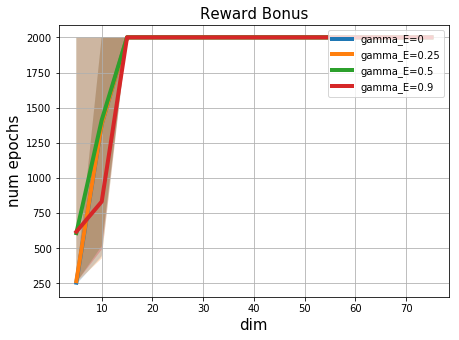

In [13]:
plot_results([rew_bonus_results], ['Reward Bonus'], dim_range)

In [14]:
%%time
ucb_results = get_gamma_E_results(SimpleChain, ucb_flag=True)


gamma_E=0


/home/liza/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log
/home/liza/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in sqrt


gamma_E=0.25
gamma_E=0.5
gamma_E=0.9
CPU times: user 10min 19s, sys: 2.26 s, total: 10min 21s
Wall time: 10min 18s


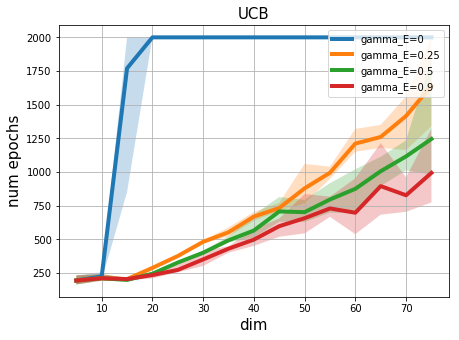

In [15]:
plot_results([ucb_results], ['UCB'], dim_range)

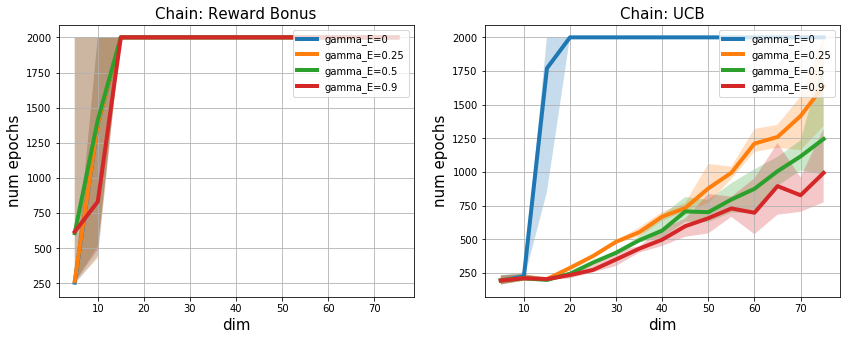

In [16]:
plot_results([rew_bonus_results, ucb_results], ['Chain: Reward Bonus', 'Chain: UCB'], dim_range)